In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import random

In [2]:
def get_data(dir,f_num):
    data = load_svmlight_file(dir,n_features=f_num) #读取数据，设定feature数量
    return data[0], data[1]


In [3]:
test_dir="./a9a.t"
train_dir="./a9a"

x_test,y_test=get_data(test_dir,123)
x_train,y_train=get_data(train_dir,123)



In [4]:
attr_num=x_train.shape[1] #属性的数量
m_test=x_test.shape[0] #test集合的样本数量
m_train=x_train.shape[0] #train集合的样本数量

x_train=x_train.todense() #化为稠密矩阵，后面方便操作
x_test=x_test.todense()  #同上

x_train=np.column_stack((np.ones(m_train),x_train)) #加一列1，作为偏置
x_test=np.column_stack((np.ones(m_test),x_test)) #加一列1，作为偏置

y_train=np.mat(y_train).T  #化为列向量
y_test=np.mat(y_test).T    #同上

print(m_test)
print(m_train)

16281
32561


In [50]:
def loss(w,x,y):   #hinge loss
    l=1-np.multiply(y,x*w)
    l2=(l>=0)
    r=np.multiply(l,l2)
    return np.mean(r)


def gradient(w,x,y,C=1):  #svm的梯度计算，包括正则项，C默认为1
    l=1-np.multiply(y,x*w)   #先做点乘
    l2=(l>=0)         #然后求出哪个元素大于等于0，化成布尔矩阵
    tmp=np.multiply(y,l2) #通过点乘进行筛选，大于等于0的项保留，小于0的项清除变为0
    return w-C*np.sum(np.multiply(x,tmp),0).T  #计算最终梯度


def accuracy(w,x,y,threshold):
    y_=x*w
    acc=np.mean(np.multiply(y_,y)>=threshold)
    return acc

In [17]:
#四种优化算法

#eta:learning rate, C: hinge-loss factor
#y:label,eta: learning rate, epoch:loop epoch,batch_size: batch size in one loop
def gradientDescent(w,x,y,eta,epoch,batch_size,C):
    loss_test=[]
    for j in range(epoch):
        i=random.randint(0,m_train-batch_size)
        #g=eta*np.mean(mul/(1+np.exp(index)),0).T-eta*lamda*w
        #w=(1-eta*lamda)*w+eta*np.mean(mul/(1+np.exp(index)),0).T
        #w=w+g
        x_t=x[i:i+batch_size]
        y_t=y[i:i+batch_size]
        #print(x_t[0])
        g=gradient(w,x_t,y_t,C)
        w=w-eta*g
        loss_test.append(loss(w,x_test,y_test))
    return w,loss_test
    
#eta:learning rate, C: hinge-loss factor
#y:label,eta: learning rate, epoch:loop epoch,m: batch size in one loop
# gamma: forget rate
    
def NAG(w,x,y,gamma,eta,epoch,C,m):
    delta_w=0
    test_loss=[]
    for i in range(epoch):
        k=random.randint(0,m_train-m)
        x_t=x[k:k+m]
        y_t=y[k:k+m]
        g=gradient(w-gamma*delta_w,x_t,y_t,C)
        delta_w=gamma*delta_w+eta*g
        w=w-delta_w
        test_loss.append(loss(w,x_test,y_test))
    return w,test_loss


#eta:learning rate, C: hinge loss factor
#y:label,eta: learning rate, epoch:loop epoch,gamma: forgetting rate, m: batch size in one loop
def RMS(w,x,y,eta,epoch,gamma,C,m):
    epison=0.0001
    G=0
    test_loss=[]
    for i in range(epoch):
        k=random.randint(0,m_train-m)
        x_t=x[k:k+m]
        y_t=y[k:k+m]
        g=gradient(w,x_t,y_t,C)
        G=gamma*G+(1-gamma)*np.square(g)
        #print(G)
        #print(E.shape)
        delta_w=eta*np.multiply(1/np.sqrt(G+epison),g)
        w=w-delta_w
        test_loss.append(loss(w,x_test,y_test))
        #print(loss(w,x_test,y_test))
    return w,test_loss

# C: hinge loss factor
#y:label,eta: learning rate, epoch:loop epoch,gamma: forgetting rate, m: batch size in one loop
def AdaDelta(w,x,y,gamma,C,epoch,m): #without learning rate
    epison=0.0001
    G=0
    delta=0
    test_loss=[]
    for i in range(epoch):
        k=random.randint(0,m_train-m)
        x_t=x[k:k+m]
        y_t=y[k:k+m]
        g=gradient(w,x_t,y_t,C)
        G=gamma*G+(1-gamma)*np.square(g)
        delta_w=-np.multiply(np.sqrt(delta+epison)/np.sqrt(G+epison),g)
        w=w+delta_w
        delta=gamma*delta+(1-gamma)*np.square(delta_w)
        test_loss.append(loss(w,x_test,y_test))
    return w,test_loss

# lamda:lambda before w if logistic regression is used, C if hinge-loss is used
#y:label,eta: learning rate, epoch:loop epoch,gamma: forgetting rate, beta: forgetting rate, m: batch size in one loop
#gradient: gradient function, loss:loss function

def Adam(w,x,y,eta,gamma,beta,epoch,batch_size,C):
    epison=0.0001
    G=0    #square mean
    m=0    #weighted mean
    delta=0
    test_loss=[]
    for i in range(epoch):
        k=random.randint(0,m_train-batch_size)
        x_t=x[k:k+batch_size]
        y_t=y[k:k+batch_size]
        g=gradient(w,x_t,y_t,C)    
        m=beta*m+(1-beta)*g
        G=gamma*G+(1-gamma)*np.square(g)     
        alpha=eta*np.sqrt(1-gamma)/(1-beta)  
        w=w-alpha*m/np.sqrt(G+epison)
        #print(loss(w,x_test,y_test))
        test_loss.append(loss(w,x_test,y_test))
    return w,test_loss

origin_w=np.random.standard_normal([attr_num+1,1])

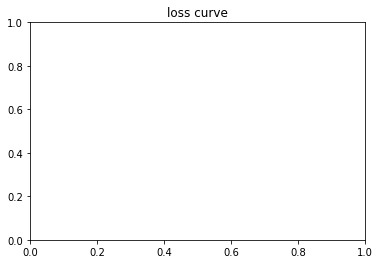

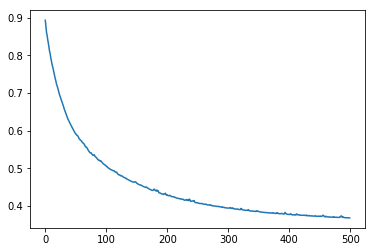

0.845341195258


In [79]:
#gradient_descent
eta=0.0008
C=0.9
epoch=500
batch_size=256
#w=np.zeros([attr_num+1,1])
w=origin_w

w,test_loss_gd=gradientDescent(w,x_train,y_train,eta,epoch,batch_size,C)
#print(x_test.shape)


iteration=list(range(epoch))
plt.figure()
plt.plot(iteration,test_loss_gd)
plt.show()

print(accuracy(w,x_test,y_test,0))

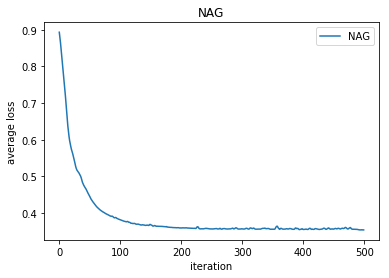

0.849579264173


In [72]:
#NAG
eta=0.0003
C=1
epoch=500
gamma=0.9
batch_size=256
#w=np.zeros([attr_num+1,1])
w=origin_w
w,test_loss_nag=NAG(w,x_train,y_train,gamma,eta,epoch,C,batch_size)

#print(w)
iteration=list(range(epoch))
plt.figure()
p1,=plt.plot(iteration,test_loss_nag)
plt.legend([p1],["NAG"])
plt.title("NAG")
plt.xlabel("iteration")
plt.ylabel("average loss")
plt.show()

print(accuracy(w,x_test,y_test,0))


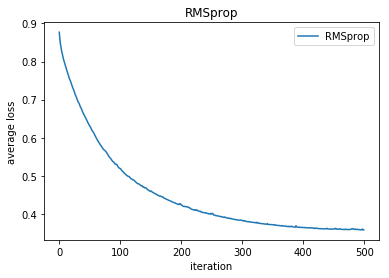

0.847859468092


In [73]:
#rms算法

eta=0.005
C=1
epoch=500
gamma=0.9
batch_size=256

#w=np.zeros([attr_num+1,1])
w=origin_w
w,test_loss_rms=RMS(w,x_train,y_train,eta,epoch,gamma,C,batch_size)

iteration=list(range(epoch))
plt.figure()
p2,=plt.plot(iteration,test_loss_rms)
plt.legend([p2],["RMSprop"])
plt.title("RMSprop")
plt.xlabel("iteration")
plt.ylabel("average loss")
plt.show()

print(accuracy(w,x_test,y_test,0))

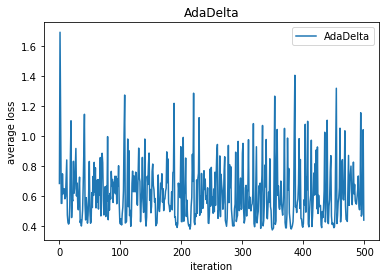

0.832565567226


In [85]:
#adaDelta
epoch=500
gamma=0.999
batch_size=256
C=1
#w=np.zeros([attr_num+1,1])
w=origin_w
w,test_loss_ada=AdaDelta(w,x_train,y_train,gamma,C,epoch,batch_size)

iteration=list(range(epoch))
plt.figure()
p3,=plt.plot(iteration,test_loss_ada)
plt.legend([p3],["AdaDelta"])
plt.title("AdaDelta")
plt.xlabel("iteration")
plt.ylabel("average loss")
plt.show()

print(accuracy(w,x_test,y_test,0))

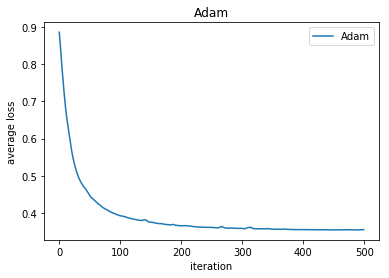

0.847859468092


In [75]:
#adam
epoch=500
gamma=0.999
eta=0.01
batch_size=256
beta=0.9
C=1
#w=np.zeros([attr_num+1,1])
w=origin_w
w,test_loss_adam=Adam(w,x_train,y_train,eta,gamma,beta,epoch,batch_size,C)

iteration=list(range(epoch))
plt.figure()
p4,=plt.plot(iteration,test_loss_adam)
plt.legend([p4],["Adam"])
plt.title("Adam")
plt.xlabel("iteration")
plt.ylabel("average loss")
plt.show()

print(accuracy(w,x_test,y_test,0))

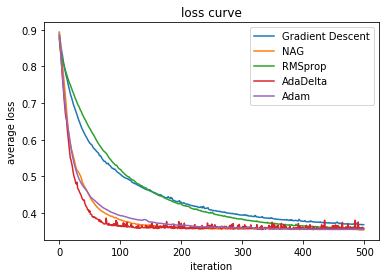

In [80]:
plt.figure()

plt.title("loss curve")

p1,=plt.plot(iteration,test_loss_gd)
p2,=plt.plot(iteration,test_loss_nag)
p3,=plt.plot(iteration,test_loss_rms)
p4,=plt.plot(iteration,test_loss_ada)
p5,=plt.plot(iteration,test_loss_adam)

plt.xlabel("iteration")
plt.ylabel("average loss")

plt.legend([p1,p2,p3,p4,p5],["Gradient Descent","NAG","RMSprop","AdaDelta","Adam"])
plt.show()